<a href="https://colab.research.google.com/github/Raivotar/Alura-Bootcamp-Data-Science/blob/main/Notebook/Projeto_Final_Alura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto Final Bootcamp DS Alura

## Imports

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn import neighbors

## Tratamento dos dados

In [2]:
df = pd.read_excel("Sirio_Libanes.xlsx")

### Agrupando os dados pelos pacientes e guardando o valor máximo para as variáveis

In [3]:
df_group = (df.groupby("PATIENT_VISIT_IDENTIFIER").max()).reset_index()
df_group.isna().sum().sum()

405

### Função que retira as variáveis com alto grau de correlação, após alguns testes, foi observado que essa função impacta negativamente o resultado do modelo e foi deixada de lado

In [4]:
def remove_corr(df_group, valor_corte):
  """
  Função responsavel por indentificar variáveis com alto
  grau de correlação e eliminar uma delas
  """
  matrix_corr = df.iloc[:,4:-2].corr().abs()
  matrix_upper = matrix_corr.where(np.triu(np.ones(matrix_corr.shape), k=1).astype(bool))
  excluir = [coluna for coluna in matrix_upper.columns if any(matrix_upper[coluna] > valor_corte)]
  return df.drop(excluir, axis=1)

df_no_corr = remove_corr(df, 0.95)

### Definição do target a ser predito e divisão do dataset em treino e validação

In [5]:
X = df_group.drop("ICU", axis=1)
y = df_group["ICU"]

X_train, X_valid, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

### Obtenção das variáveis continuas

In [6]:
num_cols = X_train.describe().columns
num_cols

Index(['PATIENT_VISIT_IDENTIFIER', 'AGE_ABOVE65', 'GENDER',
       'DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3',
       'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6', 'HTN',
       ...
       'HEART_RATE_DIFF', 'RESPIRATORY_RATE_DIFF', 'TEMPERATURE_DIFF',
       'OXYGEN_SATURATION_DIFF', 'BLOODPRESSURE_DIASTOLIC_DIFF_REL',
       'BLOODPRESSURE_SISTOLIC_DIFF_REL', 'HEART_RATE_DIFF_REL',
       'RESPIRATORY_RATE_DIFF_REL', 'TEMPERATURE_DIFF_REL',
       'OXYGEN_SATURATION_DIFF_REL'],
      dtype='object', length=228)

### Obtenção das variáveis categoricas

In [7]:
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)
object_cols

['AGE_PERCENTIL', 'WINDOW']

### Criação do Pipeline para tratamento dos dados e completar os valores nulos

In [8]:
numerical_transformer = SimpleImputer(strategy='most_frequent')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer, object_cols)
    ])

## Treinamento do modelo

In [10]:
model = LogisticRegression(max_iter=1000, random_state=42)
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])
my_pipeline.fit(X_train, y_train)
y_pred = my_pipeline.predict(X_train)

### Metricas de comparação

* Observamos uma alta acurácia na predição de teste de 96% o que poderia levar a concluir que o modelo está sofrendo de overfit.
* A acurácia no dataset de validação se mostrou menor que no dataset de teste, porem ainda apresentou um acerto de aproximadamente 90%.

In [11]:
score_train = accuracy_score(y_train, y_pred)
y_pred_valid = my_pipeline.predict(X_valid)
score_valid = accuracy_score(y_val, y_pred_valid)
print(f"Accuracy Train = {score_train:.4f}")
print(f"Accuracy Val = {score_valid:.4f}")

Accuracy Train = 0.9643
Accuracy Val = 0.8961


### Plotagem da Matriz de Confusão para avaliarmos os Falsos positivos e Falsos negativos

* No caso específico deste dataset, observamos que o caso mais crítico é quando o modelo prevê que um paciente não precisa ser internado erroneamente, no caso o Falso Negativo.
* Não podemos deixar de lado a questão de sobrecarregar o sistema hospitalar com falsos negativos, sendo assim optamos por avaliar nosso modelo pela metrica F1 score/balanced F-score/F-measure.

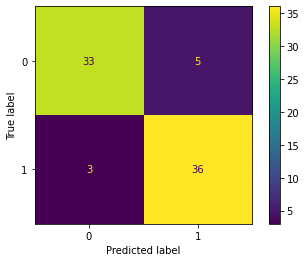

In [12]:
cm = confusion_matrix(y_val, y_pred_valid)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [13]:
print(classification_report(y_val, y_pred_valid))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89        38
           1       0.88      0.92      0.90        39

    accuracy                           0.90        77
   macro avg       0.90      0.90      0.90        77
weighted avg       0.90      0.90      0.90        77



## Validação Cruzada

Com o intuito de melhorar a credibilidade do modelo, adicionamos a validação cruzada.

In [14]:
def run_model(model):
  """
  Função responsável por rodar diversos modelos com 
  o intuito de compara-los usando o Pipeline e Cross
  Validation já definidos
  """
  my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])
  cv = StratifiedKFold(n_splits = 5,
                       shuffle = True,
                       random_state=42)
  score_cross_val = cross_val_score(my_pipeline, X, y,
                                cv=cv,
                                scoring='f1')
  # print(score_cross_val)
  # print(score_cross_val.mean())
  return score_cross_val.mean()

In [15]:
rf = RandomForestClassifier(random_state=42)
run_model(rf)

0.9301149301149302

In [16]:
lg = LogisticRegression(max_iter=1000,
                        random_state=42)
run_model(lg)

0.9101872810733571

In [17]:
gnb = GaussianNB()
run_model(gnb)

0.6622339573319842

In [18]:
knn = neighbors.KNeighborsClassifier(n_neighbors=5)
run_model(knn)

0.5079720451398951

## Tuning dos dois melhores modelos

* Observamos que o modelo Random Forest e Logistic Regression apresentram os melhores valores para a métrica F1.
* Vamos fazer alguns testes alterando os hyperparameter

Referência do código para verificação dos melhores paramentos
* https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [19]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [20]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 100,
                               cv = 3,
                               verbose=2,
                               random_state=42,
                               n_jobs = -1)

my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', rf_random)
                             ])
my_pipeline.fit(X_train, y_train)
y_pred = my_pipeline.predict(X_train)
score_train = accuracy_score(y_train, y_pred)
y_pred_valid = my_pipeline.predict(X_valid)
score_valid = accuracy_score(y_val, y_pred_valid)
print(f"Accuracy Train = {score_train:.4f}")
print(f"Accuracy Val = {score_valid:.4f}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Accuracy Train = 0.9740
Accuracy Val = 0.9221


In [21]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 90,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 400}

### Random Forest com tuning F1= 0.92

In [22]:
rf_best = RandomForestClassifier(bootstrap = True,
                                 max_depth = 10,
                                 max_features = 'auto',
                                 min_samples_leaf = 4,
                                 min_samples_split= 5,
                                 n_estimators = 200)
run_model(rf_best)

0.925517709079353

### Logistic Regression com tuning F1 = 0.91

* No caso da Logistic Regression, testamos outras maneiras de tuning semelhante ao que fizemos com o Random Forest, porem o único parametro que afetou de forma positiva o score F1 foi o max_iter.

In [23]:
score = 0
max_iter = 0
for i in [1000,2500, 5000, 7500, 10000, 15000]:
  lg = LogisticRegression(max_iter=i,
                          random_state=42)
  model_score = run_model(lg)
  if model_score > score:
    score = model_score
    max_iter = i
    
print(f"F1 = {score}, max_iter = {max_iter}")

F1 = 0.9101872810733571, max_iter = 1000


## Conclusão

O modelo Random Forest Classifier apresentou a melhor métrica f1 após o tuning dos hyperparameters. 
Sendo assim, concluimos que o modelo Random Forest Classifier deve ser colocado em produção.